In [1]:
import os
root = os.getcwd()
print(root)

/Users/kinbunhua/cs521/group


Figure 1. Samples of Nasi from the data-set:

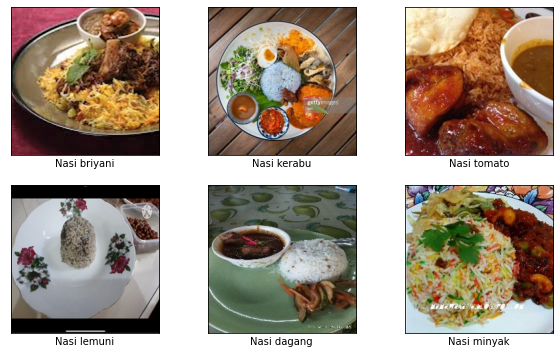

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
from tqdm import tqdm

DATADIR = root + "/Nasi"

CATEGORIES = ["Nasi briyani", "Nasi kerabu", "Nasi tomato", "Nasi lemuni", "Nasi dagang", "Nasi minyak"]

plt.figure(figsize = (10, 6))
i = 0
for category in CATEGORIES:  # do dogs and cats
    path = os.path.join(DATADIR,category)  # create path to dogs and cats
    i = i + 1
    plt.subplot(2, 3, i)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #print(path)
    for img in os.listdir(path):  # iterate over each image per dogs and cats
        #print(os.path.join(path,img))
        img_array = mpimg.imread(os.path.join(path,img))  # convert to array
        plt.imshow(img_array)  # graph it
        plt.xlabel(category)
        break  # we just want one for now so break
plt.show()  # display!

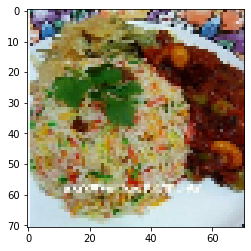

In [3]:
IMG_SIZE = 71

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [4]:
training_data = []

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))

100%|██████████| 300/300 [00:00<00:00, 615.57it/s]

1824


In [5]:
import random

random.shuffle(training_data)

In [6]:
X = []
y = []
channels = 3
num_classes = len(CATEGORIES)
INPUT_SIZE = IMG_SIZE * IMG_SIZE * channels
for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X.shape, y.shape)
#import train_test_split function
from sklearn.model_selection import train_test_split

#split the dataset into training and test sets 
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
print(num_classes)
print(y[0])
print(y[1])

6
5
2


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

#defines the options for augmentation 
datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

def image_augmentation(image, nb_of_augmentation):
    '''
    Generates new images bei augmentation 
    image : raw image 
    nb_augmentation: number of augmentations 
    images: array with new images 
    '''
    images = [] 
    image = image.reshape(1, IMG_SIZE, IMG_SIZE, channels)
    i = 0 
    for x_batch in datagen.flow(image, batch_size = 1):
        images.append(x_batch)
        i += 1 
        if i >= nb_of_augmentation:
            #interrupt augmentation 
            break 
    return images 

In [9]:
import tensorflow as tf 

def preprocess_data(images, targets, use_augmentation = False, nb_of_augmentation = 1):
    '''
    images : raw image 
    targets : target label
    use_augmentation : True if augmentation should be used 
    nb_of_augmentation : if use_augmentation = True, number of augmentations 
    '''
    X = []
    y = [] 
    for x_, y_ in zip(images, targets):
        #scaling pixels between 0.0-1.0 
        x_ = x_ / 255. 

        #data augmentation 
        if use_augmentation:
            argu_img = image_augmentation(x_, nb_of_augmentation)
            for a in argu_img:
                X.append(a.reshape(IMG_SIZE, IMG_SIZE, channels))
                y.append(y_)
        
        X.append(x_.reshape(IMG_SIZE, IMG_SIZE, channels))
        y.append(y_)

    print("*Preprocessiong completed:%i samples\n" % len(X))
    #print(X)
    firstargu = np.array(X)
    print(firstargu.shape)
    secondargu = tf.keras.utils.to_categorical(y)
    return firstargu, secondargu

In [18]:
from sklearn.model_selection import train_test_split 
batch_size = 20
num_epochs = 80   #original 80  
iterations = 1   #original 5 number of iterations

def tunning_parameter(vgg, path):
    histories = []
    for i in range(0, iterations):
        print('Running iteration:%i' % i)

        #saving the best checkpoint for each iteration 
        filepath = path % i

        X_train_, X_val_, y_train_, y_val_ = train_test_split(X_train_shaped, y_train_shaped, test_size=0.2, random_state=42)

        history = vgg.fit(
            X_train_, y_train_,
            batch_size=batch_size,
            epochs=num_epochs,
            verbose=1,
            validation_data=(X_val_, y_val_),
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
            ]
        )
        histories.append(history.history)
        return histories


In [10]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)

In [12]:
test_loss = []
test_accs = []

def get_test_loss_accs(path):
    for i in range(0, iterations): 
        cnn_ = tf.keras.models.load_model(path % i)
        
        score = cnn_.evaluate(X_test_shaped, y_test_shaped, verbose=0)
        test_loss.append(score[0])
        test_accs.append(score[1])
        
        print('running final test with model %i: %0.4f loss / %0.4f acc' % (i, score[0], score[1]))
        
    print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),np.mean(test_accs)))
    print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss),np.std(test_accs)))

In [13]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #accuracy 
    ax1.set_title("Model accuracy (%s)" % title)

    names = []

    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append("Model %i" % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')

    #Loss 
    ax2.set_title("model loss (%s)" % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc = 'upper right')
    fig.set_size_inches(20, 5)
    plt.show()

In [14]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    #Accuracy 
    ax1.set_title("Model accuracy - %s" % title)
    ax1.plot(history['accuracy'])
    ax1.plot(history['val_accuracy'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    #loss 
    ax2.set_title("model loss - %s" % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc = 'upper left')

    fig.set_size_inches(20,5)
    plt.show()

In [15]:
def plot_sample_predictions(classes, model, X_test, y_test):
    '''
    this function displays images randomly and tries to predict the correct class
    '''

    class_ = 0
    images_per_row = 3 
    rows = int(len(classes) / images_per_row)  #image_per_row
    #print(rows, X_test, y_test)
    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)
        #print(axis)
        for i, axis in enumerate(axis):
            #print(class_, i, axis)
            elements = np.squeeze(np.argwhere(y_test == class_))
            len_e = len(elements) 
            random = np.random.randint(len_e)
            #print(random, elements, elements[random])
            X = X_test[elements[random]]
            y = y_test[elements[random]]

            fig.set_size_inches(10, 20)

            x_reshape = X.reshape([1, IMG_SIZE, IMG_SIZE, channels])
            axis.text(0, 74, 'Predicted:{}'.format(classes[np.argmax(model.predict(x_reshape))]))
            axis.text(0, 78, 'Correct:{}'.format(classes[y]))
            axis.imshow(np.squeeze(X), cmap = 'gray')
            
            axis.axis('off')
            class_ += 1
    plt.show()

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools 

def plot_confusion_matrix(cm, class_, title='Confusion matrix', cmap = plt.cm.Reds):
    '''
    this function plots a confusion matrix
    '''
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j],fmt),
                horizontalalignment = 'center',
                color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

In [20]:
import tensorflow as tf 
from keras.applications import xception
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

def create_model():
    
    model = xception.Xception(include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, channels))

     #add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(256, activation='relu')(flat1)
    class2 = Dense(256, activation='relu')(class1)
    class3 = Dense(256, activation='relu')(class2)
    output = Dense(num_classes, activation='softmax')(class3)

    #define new model
    model_new = Model(inputs = model.inputs, outputs = output)

    # make all layers untrainable by freezing weights (except for last layer)
    for l, layer in enumerate(model_new.layers[:-1]):
        layer.trainable = False

    # ensure the last layer is trainable/not frozen
    for l, layer in enumerate(model_new.layers[-1:]):
        layer.trainable = True

    model_new.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model_new 


In [25]:
create_model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]']    

In [23]:
nb_augmentation = 2 #defines the number of additional augmentations of one image
X_train_shaped, y_train_shaped = preprocess_data(
    X, y,
    use_augmentation=True,
    nb_of_augmentation=nb_augmentation
)

X_test_shaped, y_test_shaped = preprocess_data(X_test, y_test)

*Preprocessiong completed:4377 samples

(4377, 71, 71, 3)
*Preprocessiong completed:365 samples

(365, 71, 71, 3)


In [29]:
histories = tunning_parameter(create_model(), 'xception_nasi-%i.hdf5')

Running iteration:0
Epoch 1/80
175/176 [============================>.] - ETA: 0s - loss: 1.7670 - accuracy: 0.2366
Epoch 1: val_loss improved from inf to 1.70824, saving model to xception_nasi-0.hdf5
176/176 [==============================] - 83s 451ms/step - loss: 1.7671 - accuracy: 0.2365 - val_loss: 1.7082 - val_accuracy: 0.3059
Epoch 2/80
175/176 [============================>.] - ETA: 0s - loss: 1.6676 - accuracy: 0.3426
Epoch 2: val_loss improved from 1.70824 to 1.64800, saving model to xception_nasi-0.hdf5
176/176 [==============================] - 77s 439ms/step - loss: 1.6675 - accuracy: 0.3428 - val_loss: 1.6480 - val_accuracy: 0.3493
Epoch 3/80
175/176 [============================>.] - ETA: 0s - loss: 1.5981 - accuracy: 0.3937
Epoch 3: val_loss improved from 1.64800 to 1.59129, saving model to xception_nasi-0.hdf5
176/176 [==============================] - 77s 437ms/step - loss: 1.5982 - accuracy: 0.3936 - val_loss: 1.5913 - val_accuracy: 0.3870
Epoch 4/80
175/176 [=======

In [32]:
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories,'loss'), get_avg(histories,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories,'val_loss'), get_avg(histories,'val_accuracy')))

Training: 	1.14913249 loss / 0.56898028 acc
Validation: 	1.35507429 loss / 0.48173517 acc


In [33]:
get_test_loss_accs("xception_nasi-%i.hdf5")

running final test with model 0: 1.3843 loss / 0.4575 acc

Average loss / accuracy on testset: 1.3843 loss / 0.45753 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc


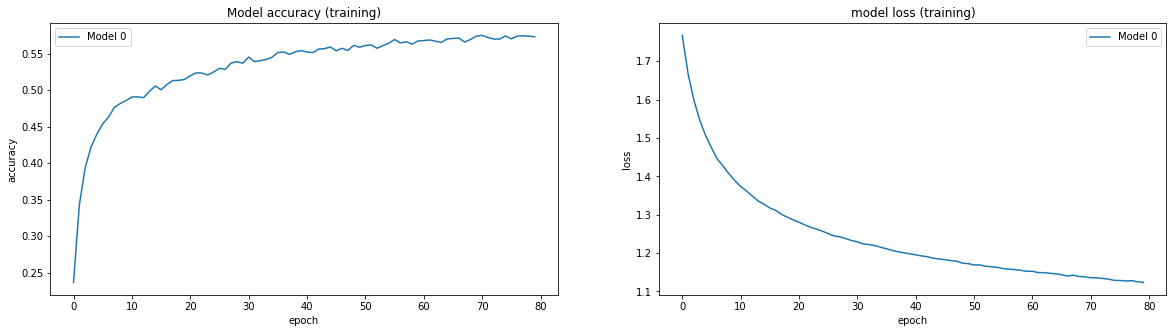

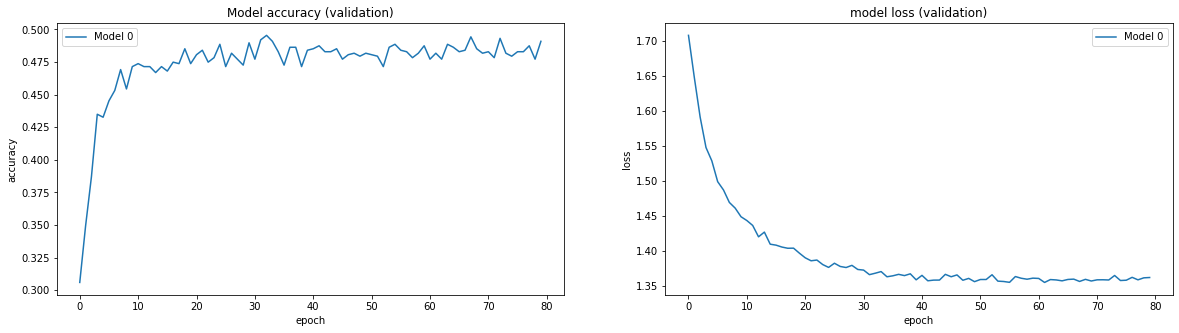

In [35]:
plot_acc_loss("training", histories, 'accuracy', 'loss')
plot_acc_loss('validation', histories, 'val_accuracy', 'val_loss')

In [37]:
RUN = 0 #you can choose one of the different models trained above 
model = create_model()
model.load_weights("xception_nasi-%i.hdf5" % RUN)

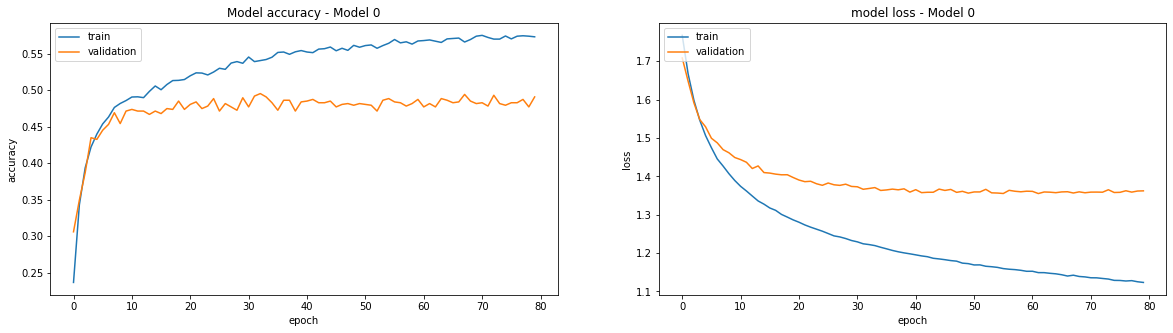

In [39]:
plot_train_val("Model %i" % RUN, histories[RUN])

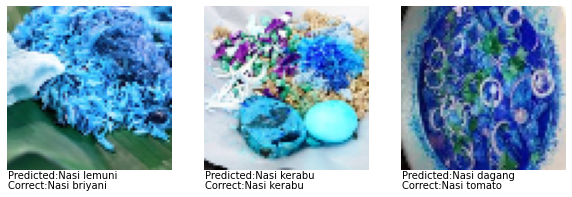

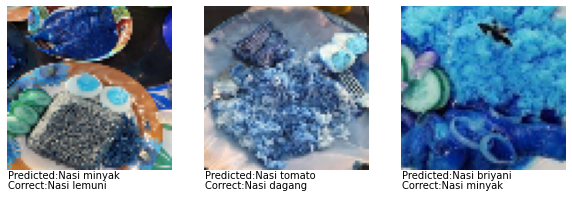

In [51]:
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))

[1 4 5 0 3 0 0 3 2 1 0 1 3 1 2 1 0 4 3 4 0 0 4 4 4 4 5 0 1 3 5 0 3 0 0 2 2
 2 2 5 0 1 0 1 0 2 4 2 3 3 4 2 3 3 5 2 4 0 0 4 3 5 2 0 3 1 1 0 0 5 4 1 3 0
 2 3 3 1 5 2 0 3 0 4 5 3 0 1 4 0 3 1 1 2 3 1 0 0 3 3 3 1 2 3 0 4 0 4 3 1 0
 1 3 5 5 1 3 0 1 3 5 5 1 0 1 0 3 0 5 4 2 2 0 1 3 1 3 2 4 0 1 3 3 2 4 0 3 2
 5 0 1 1 4 5 4 1 1 4 0 5 3 0 5 4 3 4 1 4 0 4 2 5 0 2 5 5 2 0 2 1 1 0 5 2 4
 5 3 2 1 5 1 2 0 2 3 4 3 3 0 1 1 1 3 0 3 5 3 4 1 2 0 0 5 3 5 5 2 4 4 0 2 5
 4 0 1 0 0 3 3 0 0 1 3 0 3 0 3 2 4 2 4 2 5 2 2 2 4 4 4 2 2 1 0 4 0 1 3 0 2
 3 0 4 2 3 0 2 5 1 2 2 0 4 0 5 2 5 1 5 2 2 4 3 5 1 3 4 3 2 0 0 0 4 5 3 0 4
 5 0 3 2 1 3 5 4 3 0 3 3 1 0 1 3 0 3 2 0 1 1 0 0 5 1 5 4 2 0 0 1 5 5 0 0 0
 2 3 1 0 1 4 1 3 4 4 5 4 3 5 1 5 0 3 0 0 5 0 5 1 0 2 0 4 3 0 2 3]


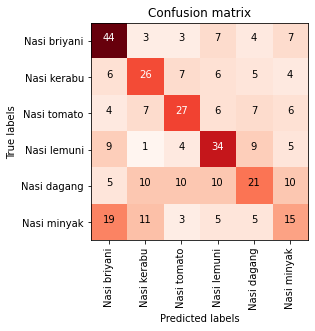

In [53]:
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
print(predictions)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))

In [54]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.51      0.65      0.57        68
           1       0.45      0.48      0.46        54
           2       0.50      0.47      0.49        57
           3       0.50      0.55      0.52        62
           4       0.41      0.32      0.36        66
           5       0.32      0.26      0.29        58

    accuracy                           0.46       365
   macro avg       0.45      0.45      0.45       365
weighted avg       0.45      0.46      0.45       365



In [17]:
def create_model2():
    
    model = xception.Xception(include_top = False, input_shape = (IMG_SIZE, IMG_SIZE, channels))

     #add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(1024, activation='relu')(flat1)
    class2 = Dense(1024, activation='relu')(class1)
    class3 = Dense(1024, activation='relu')(class2)
    output = Dense(num_classes, activation='softmax')(class3)

    #define new model
    model_new = Model(inputs = model.inputs, outputs = output)

    # make all layers untrainable by freezing weights (except for last layer)
    for l, layer in enumerate(model_new.layers[:-1]):
        layer.trainable = False

    # ensure the last layer is trainable/not frozen
    for l, layer in enumerate(model_new.layers[-1:]):
        layer.trainable = True

    model_new.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model_new 

In [21]:
create_model2().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 71, 71, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 35, 35, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 35, 35, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                                  
 block1_conv1_act (Activation)  (None, 35, 35, 32)   0           ['block1_conv1_bn[0][0]']    

In [24]:
histories2 = tunning_parameter(create_model2(), 'xception_1024_nasi-%i.hdf5')

Running iteration:0
Epoch 1/80
176/176 [==============================] - ETA: 0s - loss: 1.6311 - accuracy: 0.3556
Epoch 1: val_loss improved from inf to 1.52389, saving model to xception_1024_nasi-0.hdf5
176/176 [==============================] - 80s 434ms/step - loss: 1.6311 - accuracy: 0.3556 - val_loss: 1.5239 - val_accuracy: 0.4315
Epoch 2/80
176/176 [==============================] - ETA: 0s - loss: 1.3999 - accuracy: 0.4964
Epoch 2: val_loss improved from 1.52389 to 1.41890, saving model to xception_1024_nasi-0.hdf5
176/176 [==============================] - 76s 428ms/step - loss: 1.3999 - accuracy: 0.4964 - val_loss: 1.4189 - val_accuracy: 0.4692
Epoch 3/80
176/176 [==============================] - ETA: 0s - loss: 1.2811 - accuracy: 0.5604
Epoch 3: val_loss improved from 1.41890 to 1.32897, saving model to xception_1024_nasi-0.hdf5
176/176 [==============================] - 77s 436ms/step - loss: 1.2811 - accuracy: 0.5604 - val_loss: 1.3290 - val_accuracy: 0.5274
Epoch 4/80
1

Training: 	0.45633537 loss / 0.87175095 acc
Validation: 	0.95754391 loss / 0.65639269 acc
running final test with model 0: 1.3137 loss / 0.5781 acc

Average loss / accuracy on testset: 1.3137 loss / 0.57808 acc
Standard deviation: (+-0.0000) loss / (+-0.0000) acc
--------------1--------------


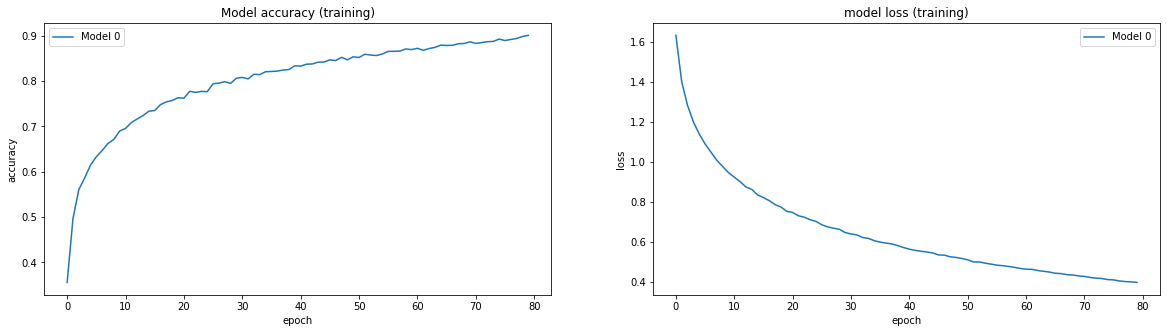

--------------2--------------


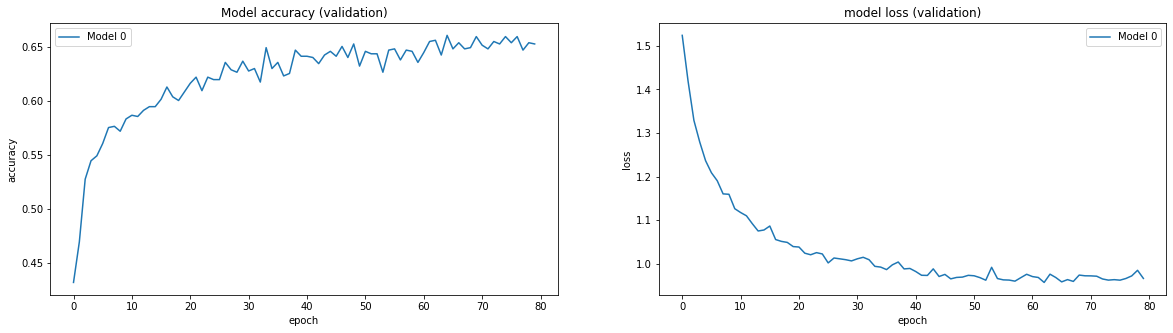

--------------3--------------


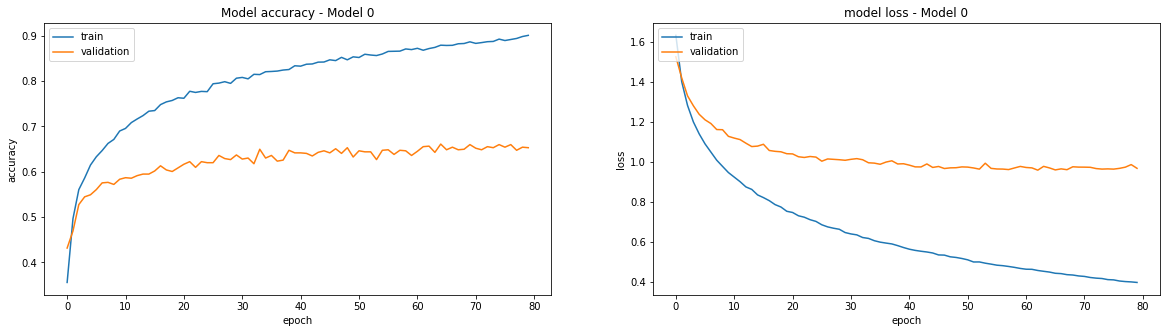

--------------4--------------


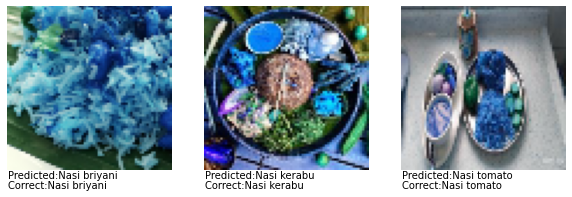

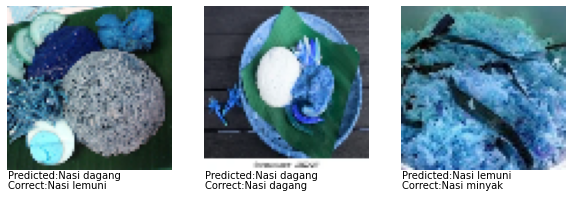

--------------5--------------


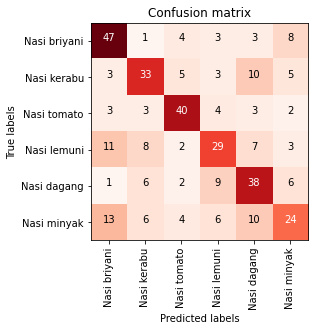

              precision    recall  f1-score   support

           0       0.60      0.71      0.65        66
           1       0.58      0.56      0.57        59
           2       0.70      0.73      0.71        55
           3       0.54      0.48      0.51        60
           4       0.54      0.61      0.57        62
           5       0.50      0.38      0.43        63

    accuracy                           0.58       365
   macro avg       0.58      0.58      0.57       365
weighted avg       0.57      0.58      0.57       365



In [28]:
print('Training: \t%0.8f loss / %0.8f acc'   % (get_avg(histories2,'loss'), get_avg(histories2,'accuracy')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories2,'val_loss'), get_avg(histories2,'val_accuracy')))

path = 'xception_1024_nasi-%i.hdf5'
get_test_loss_accs(path)
print("--------------1--------------")
plot_acc_loss("training", histories2, 'accuracy', 'loss')
print("--------------2--------------")
plot_acc_loss('validation', histories2, 'val_accuracy', 'val_loss')
print("--------------3--------------")
RUN = 0 #you can choose one of the different models trained above 
model = create_model2()
model.load_weights(path % RUN)
plot_train_val("Model %i" % RUN, histories2[RUN])
print("--------------4--------------")
plot_sample_predictions(list(CATEGORIES), model, X_test_shaped, np.array(y_test))
print("--------------5--------------")
predictions = model.predict(X_test_shaped, verbose = 0)
predictions = np.argmax(predictions, axis=1)
plot_confusion_matrix(confusion_matrix(y_test, predictions), list(CATEGORIES))
print(classification_report(y_test, predictions))